# Convolutional Neural Network (CNN)

# 1. Schritt: Audio-Dateien laden und in MFCCs umwandeln

In [1]:
import sys

import numpy as np
import os
sys.path.append(os.path.abspath(".."))

from feature_extraction import get_mfccs_from_coswara_audio_files
from feature_extraction import get_mfccs_from_virufy_audio_files
from feature_extraction import get_mfccs_from_coughvid_audio_files
from feature_extraction import get_valid_coswara_folder_names

labels_dict = {0: "neg", 1: "pos"}

labels, mfccs = [], []

p_folder_names, n_folder_names = get_valid_coswara_folder_names()

# Umwandlung der Coswara-Audio-Dateien in MFCCss
p_coswara_mfccs, p_coswara_labels = get_mfccs_from_coswara_audio_files(
    p_folder_names, is_positive=True
)

n_coswara_mfccs, n_coswara_labels = get_mfccs_from_coswara_audio_files(
    n_folder_names, is_positive=False
)

print("Positive Coswara samples: ", len(p_coswara_mfccs))
print("Negative Coswara samples: ", len(n_coswara_mfccs))

# Umwandlung der Virufy-Audio-Dateien in MFCCs
p_virufy_mfccs, p_virufy_labels = get_mfccs_from_virufy_audio_files(
    is_positive=True
)
n_virufy_mfccs, n_virufy_labels = get_mfccs_from_virufy_audio_files(
    is_positive=False
)

print("Positive Virufy samples: ", len(p_virufy_mfccs))
print("Negative Virufy samples: ", len(n_virufy_mfccs))

n_coughvid_folder_names = "neg"
p_coughvid_folder_names = "pos"

# Umwandlung der Coughvid-Audio-Dateien in MFCCs
p_coughvid_mfccs, p_coughvid_labels = get_mfccs_from_coughvid_audio_files(
    n_coughvid_folder_names,
    is_positive=True
)
n_coughvid_mfccs, n_coughvid_labels = get_mfccs_from_coughvid_audio_files(
    p_coughvid_folder_names,
    is_positive=False
)

print("Positive Coughvid samples: ", len(p_coughvid_mfccs))
print("Negative Coughvid samples: ", len(n_coughvid_mfccs))

mfcc = np.concatenate(
    (p_coswara_mfccs, n_coswara_mfccs, p_virufy_mfccs, n_virufy_mfccs,
     p_coughvid_mfccs, n_coughvid_mfccs)
)

labels = np.concatenate(
    (p_coswara_labels, n_coswara_labels, p_virufy_labels, n_virufy_labels,
     p_coughvid_labels, n_coughvid_labels)
)

mfcc = np.array(mfcc, dtype=np.float32)

labels = np.array(labels, dtype=np.int32)

print(len(mfcc), len(labels))


2025-03-06 10:12:22.429484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/paula/opt/anaconda3/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/Users/paula/opt/anaconda3/lib/python3.9/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Positive Coswara samples:  1356
Negative Coswara samples:  3098
Positive Virufy samples:  7
Negative Virufy samples:  9
Positive Coughvid samples:  9983
Negative Coughvid samples:  924
15377 15377


# 2. Schritt: Aufteilen der Daten in Trainings- und Testdaten

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


# Labels in One-Hot-Encoding umwandeln
labels = to_categorical(labels, num_classes=2)

# Train-Test-Split durchführen
# Train-Test-Split durchführen
# 80% Training, 20% Test
mfcc_train, mfcc_test, labels_train, labels_test = train_test_split(
    mfcc, labels, test_size=0.2, random_state=42
)

print(
    f"""mfcc_train.shape: {mfcc_train.shape},
    labels_train.shape: {labels_train.shape}"""
)
print(
    f"""mfcc_test.shape: {mfcc_test.shape},
    labels_test.shape: {labels_test.shape}"""
)


mfcc_train.shape: (12301, 128, 1),
    labels_train.shape: (12301, 2)
mfcc_test.shape: (3076, 128, 1),
    labels_test.shape: (3076, 2)


# 3. Schritt: CNN-Modelle erstellen

In [20]:
# Konfiguration des Trainingsprozesses
BATCH_SIZE = 32
EPOCHS = 50
ACTIVATION_1 = "relu"
ACTIVATION_2 = "softmax"
METRIC = "accuracy"
LOSS = "binary_crossentropy"
OPTIMIZER = "adam"


## 3.1. Experiment: Geeignetes CNN-Modell finden

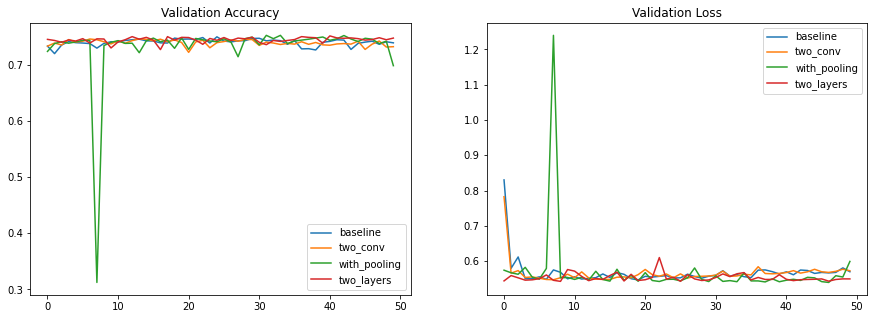


baseline:
Final val_accuracy: 0.7389
Final val_loss: 0.5696

two_conv:
Final val_accuracy: 0.7321
Final val_loss: 0.5724

with_pooling:
Final val_accuracy: 0.6983
Final val_loss: 0.5989

two_layers:
Final val_accuracy: 0.7474
Final val_loss: 0.5493


In [13]:
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input

def experiment_architectures(x_train, y_train, x_val, y_val):
    """
    Experimentieren mit verschiedenen Architekturen

    :param x_train: Trainingsdaten
    :param y_train: Trainingslabels
    :param x_val: Validierungsdaten
    :param y_val: Validierungslabels
    """
    results = {}
    input_shape = mfcc[0].shape

    # Test 1: Basismodell
    model1 = Sequential([
        Input(shape=input_shape),
        Conv1D(32, 3, activation=ACTIVATION_1),
        MaxPooling1D(2),
        Flatten(),
        Dense(len(labels_dict), activation=ACTIVATION_2)
    ])
    model1.compile(
        optimizer=OPTIMIZER,
        loss=LOSS,
        metrics=[METRIC]
    )
    history1 = model1.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=0
    )
    results['baseline'] = history1.history

    # Test 2: Zwei Convolutional Layers
    model2 = Sequential([
        Input(shape=input_shape),
        Conv1D(32, 3, activation=ACTIVATION_1),
        MaxPooling1D(2),
        Flatten(),
        Dense(len(labels_dict), activation=ACTIVATION_2)
    ])
    model2.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[METRIC])
    history2 = model2.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=0)
    results['two_conv'] = history2.history

    # Test 3: Dropout Layer
    model3 = Sequential([
        Input(shape=input_shape),
        Conv1D(32, 3, activation=ACTIVATION_1),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.2),
        Flatten(),
        Dense(len(labels_dict), activation=ACTIVATION_2)
    ])
    model3.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[METRIC])
    history3 = model3.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=0)
    results['with_pooling'] = history3.history

    # Test 3: Two Convolutional Layers
    model4 = Sequential([
        Input(shape=input_shape),
        Conv1D(64, 3, activation=ACTIVATION_1),
        Conv1D(32, 3, activation=ACTIVATION_1),
        MaxPooling1D(2),
        Dropout(0.2),
        Flatten(),
        Dense(len(labels_dict), activation=ACTIVATION_2)
    ])
    model4.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[METRIC])
    history4 = model3.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=0)
    results['two_layers'] = history4.history

    return results

def analyze_results(results):
    """
    Analyse der Ergebnisse

    :param results: Ergebnisse der Experimente
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    for name, history in results.items():
        plt.plot(history['val_accuracy'], label=f'{name}')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    for name, history in results.items():
        plt.plot(history['val_loss'], label=f'{name}')
    plt.title('Validation Loss')
    plt.legend()
    plt.show()

    for name, history in results.items():
        print(f"\n{name}:")
        print(f"Final val_accuracy: {history['val_accuracy'][-1]:.4f}")
        print(f"Final val_loss: {history['val_loss'][-1]:.4f}")

results = experiment_architectures(mfcc_train, labels_train, mfcc_test, labels_test)
analyze_results(results)



# 3.1. Schritt: CNN mit kausaler Faltung

In [21]:
def build_cnn(*, include_future: bool) -> Sequential:
    """Erstellt ein CNN-Modell, das auf den MFCCs trainiert wird.

    :param include_future: Boolean, ob die Zukunft berücksichtigt werden soll
    :return: CNN-Modell (TensorFlow Sequential Model)
    """
    # Eingabeform: (128, 128, 1)
    input_shape = mfcc[0].shape

    padding_value = "valid"
    if not include_future:
        padding_value = "causal"

    model = Sequential([
        # Weitere Testmodelle
        # Conv1D(32, kernel_size=3, activation=ACTIVATION_2, padding=padding_value),
        # BatchNormalization(),
        # Conv1D(32, kernel_size=3, activation=ACTIVATION_2, padding=padding_value),
        # MaxPooling1D(2),
        # Dropout(0.2),

        # Conv1D(64, kernel_size=3, activation=ACTIVATION_2, padding=padding_value),
        # BatchNormalization(),
        # Conv1D(64, 3, activation=ACTIVATION_2, padding=padding_value),
        # MaxPooling1D(2),
        # Dropout(0.2),

        # Conv1D(128, kernel_size=3, activation=ACTIVATION_2, padding=padding_value),
        # BatchNormalization(),
        # Conv1D(128, 3, activation=ACTIVATION_2, padding=padding_value),
        # GlobalAveragePooling1D(),

        # # Dense Layers
        # Dense(256, activation=ACTIVATION_2),
        # BatchNormalization(),
        # Dropout(0.5),
        # Dense(128, activation=ACTIVATION_2),
        # BatchNormalization(),
        # Dropout(0.5),
        # Dense(64, activation=ACTIVATION_2),
        Input(shape=input_shape),
        Conv1D(32, 3, activation=ACTIVATION_1, padding=padding_value),
        MaxPooling1D(2),
        Dropout(0.2),
        Flatten(),
        Dense(len(labels_dict), activation=ACTIVATION_2)

    ])

    model.summary()
    return model


In [22]:
# Modell erstellen, was die Zukunft nicht berücksichtigt
causal_model = build_cnn(include_future=False)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 128, 32)           128       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 64, 32)           0         
 g1D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 64, 32)            0         
                                                                 
 flatten_12 (Flatten)        (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 4,226
Trainable params: 4,226
Non-trainable params: 0
___________________________________________________

# 3.2. Schritt: CNN mit normaler Faltung

In [23]:
# Modell erstellen, was die Zukunft berücksichtigt
non_causal_model = build_cnn(include_future=True)


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 126, 32)           128       
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 63, 32)           0         
 g1D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 63, 32)            0         
                                                                 
 flatten_13 (Flatten)        (None, 2016)              0         
                                                                 
 dense_13 (Dense)            (None, 2)                 4034      
                                                                 
Total params: 4,162
Trainable params: 4,162
Non-trainable params: 0
___________________________________________________

# 4. Modell kompilieren

In [24]:
# Modelle werden für das Training vorbereitet
# Optimierungsalgorithmus: Adam (Optimierungsalgorithmus) (Wie werden die
# Gewichte angepasst)
# Verlustfunktion: Categorical Crossentropy (Wie werden die Fehler berechnet)
# Metrik: Genauigkeit (Welche Metrik wird zur Bewertung des Modells verwendet)
causal_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[METRIC])
non_causal_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[METRIC])


#  5 Schritt: W&B Project initialisieren und Modell trainieren

In [25]:
def train_and_wandbLog(
    model, mfcc_train, labels_train, mfcc_test, labels_test, *, with_future: bool
):
    """Trainiert das Modell und loggt die Metriken in Weights & Biases.

    :param model: Modell, das trainiert werden soll
    :param mfcc_train: Trainingsdaten (MFCCs)
    :param labels_train: Trainingsdaten (Labels)
    :param mfcc_test: Testdaten (MFCCs)
    :param labels_test: Testdaten (Labels)
    :param with_future: Boolean, ob die Zukunft berücksichtigt werden soll
    :return: History-Objekt des Trainingsprozesses
    """
    import wandb

    wandb.init(
        project="cnn_covid_audio_classification",
        config={
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "architecture": "CNN",
            "dataset": "coswara + virufy + coughvid",
            "activation_1": ACTIVATION_1,
            "activation_2": ACTIVATION_2,
            "metric": METRIC,
            "loss": LOSS,
            "optimizer": OPTIMIZER,
        },
    )

    # WandB Run Name setzen
    FUTURE = "FUTURE" if with_future else "NO_FUTURE"
    wandb.run.name = f"{FUTURE}_batch_size_{BATCH_SIZE}_epochs_{EPOCHS}_activation_1_{ACTIVATION_1}_activation_2_{ACTIVATION_2}_metric_{METRIC}_loss_{LOSS}_optimizer_{OPTIMIZER}"

    history = model.fit(
        mfcc_train,
        labels_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(mfcc_test, labels_test),
        callbacks=[
            wandb.keras.WandbMetricsLogger(log_freq=5),
            wandb.keras.WandbModelCheckpoint("models"),
        ],
    )

    history = model.fit(
        mfcc_train,
        labels_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(mfcc_test, labels_test),
    )

    # wandb.finish()
    return history


In [26]:
# Training des Modells
history = train_and_wandbLog(
    non_causal_model, mfcc_train, labels_train, mfcc_test, labels_test, with_future=True
)
test_loss, test_acc = non_causal_model.evaluate(mfcc_test, labels_test, verbose=2)

print("\nTest accuracy:", test_acc)
test_loss, test_acc = non_causal_model.evaluate(mfcc_test, labels_test, verbose=2)


Epoch 1/50
378/385 [============================>.] - ETA: 0s - loss: 0.8965 - accuracy: 0.7011

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 4ms/step - loss: 0.8919 - accuracy: 0.7012 - val_loss: 0.5690 - val_accuracy: 0.7324
Epoch 2/50
383/385 [============================>.] - ETA: 0s - loss: 0.5632 - accuracy: 0.7392

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5635 - accuracy: 0.7389 - val_loss: 0.5563 - val_accuracy: 0.7354
Epoch 3/50
374/385 [============================>.] - ETA: 0s - loss: 0.5482 - accuracy: 0.7406

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 4ms/step - loss: 0.5480 - accuracy: 0.7408 - val_loss: 0.5553 - val_accuracy: 0.7389
Epoch 4/50
362/385 [===========================>..] - ETA: 0s - loss: 0.5413 - accuracy: 0.7446

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5435 - accuracy: 0.7447 - val_loss: 0.5547 - val_accuracy: 0.7337
Epoch 5/50
366/385 [===========================>..] - ETA: 0s - loss: 0.5401 - accuracy: 0.7451

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5402 - accuracy: 0.7450 - val_loss: 0.5533 - val_accuracy: 0.7331
Epoch 6/50
374/385 [============================>.] - ETA: 0s - loss: 0.5378 - accuracy: 0.7462

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5376 - accuracy: 0.7469 - val_loss: 0.5492 - val_accuracy: 0.7402
Epoch 7/50
370/385 [===========================>..] - ETA: 0s - loss: 0.5370 - accuracy: 0.7477

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 3ms/step - loss: 0.5378 - accuracy: 0.7465 - val_loss: 0.5508 - val_accuracy: 0.7376
Epoch 8/50
379/385 [============================>.] - ETA: 0s - loss: 0.5327 - accuracy: 0.7503

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5332 - accuracy: 0.7502 - val_loss: 0.5511 - val_accuracy: 0.7331
Epoch 9/50
360/385 [===========================>..] - ETA: 0s - loss: 0.5351 - accuracy: 0.7492

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5349 - accuracy: 0.7494 - val_loss: 0.5499 - val_accuracy: 0.7389
Epoch 10/50
377/385 [============================>.] - ETA: 0s - loss: 0.5331 - accuracy: 0.7472

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5337 - accuracy: 0.7469 - val_loss: 0.5531 - val_accuracy: 0.7393
Epoch 11/50
384/385 [============================>.] - ETA: 0s - loss: 0.5308 - accuracy: 0.7521

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5308 - accuracy: 0.7521 - val_loss: 0.5540 - val_accuracy: 0.7341
Epoch 12/50
379/385 [============================>.] - ETA: 0s - loss: 0.5283 - accuracy: 0.7523

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 5ms/step - loss: 0.5287 - accuracy: 0.7522 - val_loss: 0.5492 - val_accuracy: 0.7396
Epoch 13/50
375/385 [============================>.] - ETA: 0s - loss: 0.5281 - accuracy: 0.7539

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5292 - accuracy: 0.7533 - val_loss: 0.5582 - val_accuracy: 0.7363
Epoch 14/50
371/385 [===========================>..] - ETA: 0s - loss: 0.5290 - accuracy: 0.7513

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5286 - accuracy: 0.7512 - val_loss: 0.5520 - val_accuracy: 0.7399
Epoch 15/50
372/385 [===========================>..] - ETA: 0s - loss: 0.5268 - accuracy: 0.7518

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 4ms/step - loss: 0.5263 - accuracy: 0.7522 - val_loss: 0.5533 - val_accuracy: 0.7354
Epoch 16/50
382/385 [============================>.] - ETA: 0s - loss: 0.5264 - accuracy: 0.7521

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 4ms/step - loss: 0.5264 - accuracy: 0.7522 - val_loss: 0.5571 - val_accuracy: 0.7386
Epoch 17/50
378/385 [============================>.] - ETA: 0s - loss: 0.5248 - accuracy: 0.7529

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5248 - accuracy: 0.7526 - val_loss: 0.5533 - val_accuracy: 0.7389
Epoch 18/50
363/385 [===========================>..] - ETA: 0s - loss: 0.5261 - accuracy: 0.7513

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5253 - accuracy: 0.7512 - val_loss: 0.5550 - val_accuracy: 0.7409
Epoch 19/50
373/385 [============================>.] - ETA: 0s - loss: 0.5241 - accuracy: 0.7523

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5251 - accuracy: 0.7515 - val_loss: 0.5530 - val_accuracy: 0.7425
Epoch 20/50
362/385 [===========================>..] - ETA: 0s - loss: 0.5245 - accuracy: 0.7545

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5241 - accuracy: 0.7552 - val_loss: 0.5500 - val_accuracy: 0.7415
Epoch 21/50
358/385 [==========================>...] - ETA: 0s - loss: 0.5232 - accuracy: 0.7547

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5241 - accuracy: 0.7538 - val_loss: 0.5488 - val_accuracy: 0.7409
Epoch 22/50
361/385 [===========================>..] - ETA: 0s - loss: 0.5215 - accuracy: 0.7559

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5212 - accuracy: 0.7553 - val_loss: 0.5554 - val_accuracy: 0.7373
Epoch 23/50
373/385 [============================>.] - ETA: 0s - loss: 0.5208 - accuracy: 0.7520

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 3ms/step - loss: 0.5191 - accuracy: 0.7534 - val_loss: 0.5578 - val_accuracy: 0.7406
Epoch 24/50
374/385 [============================>.] - ETA: 0s - loss: 0.5198 - accuracy: 0.7562

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 3ms/step - loss: 0.5200 - accuracy: 0.7561 - val_loss: 0.5482 - val_accuracy: 0.7383
Epoch 25/50
383/385 [============================>.] - ETA: 0s - loss: 0.5175 - accuracy: 0.7586

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5176 - accuracy: 0.7584 - val_loss: 0.5495 - val_accuracy: 0.7412
Epoch 26/50
378/385 [============================>.] - ETA: 0s - loss: 0.5197 - accuracy: 0.7562

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 3ms/step - loss: 0.5188 - accuracy: 0.7569 - val_loss: 0.5563 - val_accuracy: 0.7357
Epoch 27/50
371/385 [===========================>..] - ETA: 0s - loss: 0.5184 - accuracy: 0.7570

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 3ms/step - loss: 0.5180 - accuracy: 0.7568 - val_loss: 0.5520 - val_accuracy: 0.7412
Epoch 28/50
364/385 [===========================>..] - ETA: 0s - loss: 0.5170 - accuracy: 0.7568

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5175 - accuracy: 0.7556 - val_loss: 0.5495 - val_accuracy: 0.7396
Epoch 29/50
360/385 [===========================>..] - ETA: 0s - loss: 0.5210 - accuracy: 0.7556

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5179 - accuracy: 0.7582 - val_loss: 0.5551 - val_accuracy: 0.7357
Epoch 30/50
380/385 [============================>.] - ETA: 0s - loss: 0.5184 - accuracy: 0.7551

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 3ms/step - loss: 0.5178 - accuracy: 0.7555 - val_loss: 0.5533 - val_accuracy: 0.7337
Epoch 31/50
375/385 [============================>.] - ETA: 0s - loss: 0.5153 - accuracy: 0.7575

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 4ms/step - loss: 0.5141 - accuracy: 0.7582 - val_loss: 0.5572 - val_accuracy: 0.7357
Epoch 32/50
372/385 [===========================>..] - ETA: 0s - loss: 0.5154 - accuracy: 0.7560

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 3ms/step - loss: 0.5145 - accuracy: 0.7571 - val_loss: 0.5579 - val_accuracy: 0.7373
Epoch 33/50
365/385 [===========================>..] - ETA: 0s - loss: 0.5138 - accuracy: 0.7594

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5141 - accuracy: 0.7595 - val_loss: 0.5495 - val_accuracy: 0.7376
Epoch 34/50
374/385 [============================>.] - ETA: 0s - loss: 0.5142 - accuracy: 0.7584

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5160 - accuracy: 0.7573 - val_loss: 0.5513 - val_accuracy: 0.7386
Epoch 35/50
360/385 [===========================>..] - ETA: 0s - loss: 0.5146 - accuracy: 0.7576

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5154 - accuracy: 0.7581 - val_loss: 0.5508 - val_accuracy: 0.7337
Epoch 36/50
372/385 [===========================>..] - ETA: 0s - loss: 0.5184 - accuracy: 0.7574

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5191 - accuracy: 0.7565 - val_loss: 0.5588 - val_accuracy: 0.7347
Epoch 37/50
379/385 [============================>.] - ETA: 0s - loss: 0.5138 - accuracy: 0.7557

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5147 - accuracy: 0.7551 - val_loss: 0.5515 - val_accuracy: 0.7386
Epoch 38/50
374/385 [============================>.] - ETA: 0s - loss: 0.5124 - accuracy: 0.7568

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5123 - accuracy: 0.7567 - val_loss: 0.5504 - val_accuracy: 0.7409
Epoch 39/50
372/385 [===========================>..] - ETA: 0s - loss: 0.5132 - accuracy: 0.7573

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 4ms/step - loss: 0.5147 - accuracy: 0.7561 - val_loss: 0.5536 - val_accuracy: 0.7370
Epoch 40/50
371/385 [===========================>..] - ETA: 0s - loss: 0.5125 - accuracy: 0.7575

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5129 - accuracy: 0.7574 - val_loss: 0.5512 - val_accuracy: 0.7396
Epoch 41/50
369/385 [===========================>..] - ETA: 0s - loss: 0.5106 - accuracy: 0.7591

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5110 - accuracy: 0.7586 - val_loss: 0.5496 - val_accuracy: 0.7380
Epoch 42/50
357/385 [==========================>...] - ETA: 0s - loss: 0.5140 - accuracy: 0.7580

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5147 - accuracy: 0.7568 - val_loss: 0.5534 - val_accuracy: 0.7419
Epoch 43/50
375/385 [============================>.] - ETA: 0s - loss: 0.5132 - accuracy: 0.7606

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 3ms/step - loss: 0.5134 - accuracy: 0.7605 - val_loss: 0.5552 - val_accuracy: 0.7347
Epoch 44/50
369/385 [===========================>..] - ETA: 0s - loss: 0.5101 - accuracy: 0.7580

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5114 - accuracy: 0.7568 - val_loss: 0.5572 - val_accuracy: 0.7337
Epoch 45/50
364/385 [===========================>..] - ETA: 0s - loss: 0.5112 - accuracy: 0.7564

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 3ms/step - loss: 0.5105 - accuracy: 0.7568 - val_loss: 0.5547 - val_accuracy: 0.7396
Epoch 46/50
364/385 [===========================>..] - ETA: 0s - loss: 0.5089 - accuracy: 0.7600

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5103 - accuracy: 0.7586 - val_loss: 0.5537 - val_accuracy: 0.7412
Epoch 47/50
360/385 [===========================>..] - ETA: 0s - loss: 0.5119 - accuracy: 0.7595

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 3ms/step - loss: 0.5109 - accuracy: 0.7600 - val_loss: 0.5564 - val_accuracy: 0.7363
Epoch 48/50
379/385 [============================>.] - ETA: 0s - loss: 0.5091 - accuracy: 0.7605

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 3ms/step - loss: 0.5092 - accuracy: 0.7605 - val_loss: 0.5519 - val_accuracy: 0.7386
Epoch 49/50
376/385 [============================>.] - ETA: 0s - loss: 0.5075 - accuracy: 0.7596

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5081 - accuracy: 0.7589 - val_loss: 0.5519 - val_accuracy: 0.7354
Epoch 50/50
373/385 [============================>.] - ETA: 0s - loss: 0.5095 - accuracy: 0.7622

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 5ms/step - loss: 0.5099 - accuracy: 0.7619 - val_loss: 0.5562 - val_accuracy: 0.7383
Epoch 1/50
385/385 [==============================] - 1s 2ms/step - loss: 0.5105 - accuracy: 0.7571 - val_loss: 0.5551 - val_accuracy: 0.7370
Epoch 2/50
385/385 [==============================] - 1s 2ms/step - loss: 0.5110 - accuracy: 0.7583 - val_loss: 0.5570 - val_accuracy: 0.7419
Epoch 3/50
385/385 [==============================] - 1s 2ms/step - loss: 0.5065 - accuracy: 0.7577 - val_loss: 0.5540 - val_accuracy: 0.7383
Epoch 4/50
385/385 [==============================] - 1s 2ms/step - loss: 0.5101 - accuracy: 0.7590 - val_loss: 0.5594 - val_accuracy: 0.7367
Epoch 5/50
385/385 [==============================] - 1s 2ms/step - loss: 0.5066 - accuracy: 0.7587 - val_loss: 0.5544 - val_accuracy: 0.7367
Epoch 6/50
385/385 [==============================] - 1s 2ms/step - loss: 0.5091 - accuracy: 0.7602 - val_loss: 0.5550 - val_accuracy: 0.7419
Epoch 7/50
385/38

In [27]:
causal_history = train_and_wandbLog(
    causal_model, mfcc_train, labels_train, mfcc_test, labels_test, with_future=False,
)


print("\nTest accuracy:", test_acc)
test_loss, test_acc = causal_model.evaluate(mfcc_test, labels_test, verbose=2)


Epoch 1/50
364/385 [===========================>..] - ETA: 0s - loss: 0.7287 - accuracy: 0.7109

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 4ms/step - loss: 0.7204 - accuracy: 0.7133 - val_loss: 0.5583 - val_accuracy: 0.7331
Epoch 2/50
365/385 [===========================>..] - ETA: 0s - loss: 0.5612 - accuracy: 0.7411

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5607 - accuracy: 0.7414 - val_loss: 0.5539 - val_accuracy: 0.7354
Epoch 3/50
385/385 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.7451

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5503 - accuracy: 0.7451 - val_loss: 0.5691 - val_accuracy: 0.7360
Epoch 4/50
380/385 [============================>.] - ETA: 0s - loss: 0.5431 - accuracy: 0.7461

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5440 - accuracy: 0.7455 - val_loss: 0.5534 - val_accuracy: 0.7350
Epoch 5/50
362/385 [===========================>..] - ETA: 0s - loss: 0.5432 - accuracy: 0.7431

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5414 - accuracy: 0.7452 - val_loss: 0.5563 - val_accuracy: 0.7373
Epoch 6/50
377/385 [============================>.] - ETA: 0s - loss: 0.5395 - accuracy: 0.7465

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 4ms/step - loss: 0.5392 - accuracy: 0.7469 - val_loss: 0.5522 - val_accuracy: 0.7363
Epoch 7/50
364/385 [===========================>..] - ETA: 0s - loss: 0.5326 - accuracy: 0.7487

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5342 - accuracy: 0.7480 - val_loss: 0.5462 - val_accuracy: 0.7373
Epoch 8/50
363/385 [===========================>..] - ETA: 0s - loss: 0.5309 - accuracy: 0.7511

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 4ms/step - loss: 0.5320 - accuracy: 0.7505 - val_loss: 0.5477 - val_accuracy: 0.7412
Epoch 9/50
366/385 [===========================>..] - ETA: 0s - loss: 0.5314 - accuracy: 0.7520

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5311 - accuracy: 0.7516 - val_loss: 0.5499 - val_accuracy: 0.7412
Epoch 10/50
364/385 [===========================>..] - ETA: 0s - loss: 0.5306 - accuracy: 0.7498

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 4ms/step - loss: 0.5310 - accuracy: 0.7497 - val_loss: 0.5509 - val_accuracy: 0.7419
Epoch 11/50
368/385 [===========================>..] - ETA: 0s - loss: 0.5271 - accuracy: 0.7510

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5267 - accuracy: 0.7509 - val_loss: 0.5535 - val_accuracy: 0.7409
Epoch 12/50
376/385 [============================>.] - ETA: 0s - loss: 0.5274 - accuracy: 0.7518

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 4ms/step - loss: 0.5288 - accuracy: 0.7507 - val_loss: 0.5586 - val_accuracy: 0.7383
Epoch 13/50
368/385 [===========================>..] - ETA: 0s - loss: 0.5292 - accuracy: 0.7524

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5283 - accuracy: 0.7534 - val_loss: 0.5524 - val_accuracy: 0.7376
Epoch 14/50
370/385 [===========================>..] - ETA: 0s - loss: 0.5290 - accuracy: 0.7519

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5282 - accuracy: 0.7526 - val_loss: 0.5491 - val_accuracy: 0.7415
Epoch 15/50
367/385 [===========================>..] - ETA: 0s - loss: 0.5255 - accuracy: 0.7519

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5251 - accuracy: 0.7529 - val_loss: 0.5464 - val_accuracy: 0.7383
Epoch 16/50
363/385 [===========================>..] - ETA: 0s - loss: 0.5235 - accuracy: 0.7545

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5254 - accuracy: 0.7526 - val_loss: 0.5514 - val_accuracy: 0.7419
Epoch 17/50
368/385 [===========================>..] - ETA: 0s - loss: 0.5244 - accuracy: 0.7528

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5254 - accuracy: 0.7519 - val_loss: 0.5481 - val_accuracy: 0.7389
Epoch 18/50
378/385 [============================>.] - ETA: 0s - loss: 0.5249 - accuracy: 0.7521

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 5ms/step - loss: 0.5246 - accuracy: 0.7529 - val_loss: 0.5722 - val_accuracy: 0.7376
Epoch 19/50
368/385 [===========================>..] - ETA: 0s - loss: 0.5245 - accuracy: 0.7523

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5234 - accuracy: 0.7528 - val_loss: 0.5504 - val_accuracy: 0.7383
Epoch 20/50
377/385 [============================>.] - ETA: 0s - loss: 0.5212 - accuracy: 0.7540

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5224 - accuracy: 0.7527 - val_loss: 0.5483 - val_accuracy: 0.7422
Epoch 21/50
375/385 [============================>.] - ETA: 0s - loss: 0.5182 - accuracy: 0.7591

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5188 - accuracy: 0.7582 - val_loss: 0.5507 - val_accuracy: 0.7376
Epoch 22/50
381/385 [============================>.] - ETA: 0s - loss: 0.5223 - accuracy: 0.7528

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5230 - accuracy: 0.7523 - val_loss: 0.5542 - val_accuracy: 0.7383
Epoch 23/50
371/385 [===========================>..] - ETA: 0s - loss: 0.5195 - accuracy: 0.7553

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5196 - accuracy: 0.7543 - val_loss: 0.5546 - val_accuracy: 0.7373
Epoch 24/50
375/385 [============================>.] - ETA: 0s - loss: 0.5148 - accuracy: 0.7570

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5160 - accuracy: 0.7562 - val_loss: 0.5681 - val_accuracy: 0.7357
Epoch 25/50
377/385 [============================>.] - ETA: 0s - loss: 0.5212 - accuracy: 0.7546

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5216 - accuracy: 0.7543 - val_loss: 0.5548 - val_accuracy: 0.7357
Epoch 26/50
369/385 [===========================>..] - ETA: 0s - loss: 0.5190 - accuracy: 0.7560

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5195 - accuracy: 0.7556 - val_loss: 0.5539 - val_accuracy: 0.7350
Epoch 27/50
380/385 [============================>.] - ETA: 0s - loss: 0.5210 - accuracy: 0.7530

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5205 - accuracy: 0.7536 - val_loss: 0.5496 - val_accuracy: 0.7370
Epoch 28/50
366/385 [===========================>..] - ETA: 0s - loss: 0.5195 - accuracy: 0.7563

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5200 - accuracy: 0.7553 - val_loss: 0.5505 - val_accuracy: 0.7438
Epoch 29/50
370/385 [===========================>..] - ETA: 0s - loss: 0.5161 - accuracy: 0.7575

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5167 - accuracy: 0.7570 - val_loss: 0.5510 - val_accuracy: 0.7386
Epoch 30/50
362/385 [===========================>..] - ETA: 0s - loss: 0.5181 - accuracy: 0.7541

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5189 - accuracy: 0.7546 - val_loss: 0.5530 - val_accuracy: 0.7376
Epoch 31/50
361/385 [===========================>..] - ETA: 0s - loss: 0.5155 - accuracy: 0.7572

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5158 - accuracy: 0.7577 - val_loss: 0.5497 - val_accuracy: 0.7357
Epoch 32/50
371/385 [===========================>..] - ETA: 0s - loss: 0.5141 - accuracy: 0.7588

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5136 - accuracy: 0.7594 - val_loss: 0.5513 - val_accuracy: 0.7389
Epoch 33/50
369/385 [===========================>..] - ETA: 0s - loss: 0.5172 - accuracy: 0.7563

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5175 - accuracy: 0.7564 - val_loss: 0.5506 - val_accuracy: 0.7383
Epoch 34/50
365/385 [===========================>..] - ETA: 0s - loss: 0.5131 - accuracy: 0.7607

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5153 - accuracy: 0.7586 - val_loss: 0.5633 - val_accuracy: 0.7298
Epoch 35/50
368/385 [===========================>..] - ETA: 0s - loss: 0.5164 - accuracy: 0.7565

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5166 - accuracy: 0.7565 - val_loss: 0.5470 - val_accuracy: 0.7399
Epoch 36/50
379/385 [============================>.] - ETA: 0s - loss: 0.5129 - accuracy: 0.7567

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5136 - accuracy: 0.7562 - val_loss: 0.5483 - val_accuracy: 0.7393
Epoch 37/50
379/385 [============================>.] - ETA: 0s - loss: 0.5102 - accuracy: 0.7587

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 5ms/step - loss: 0.5115 - accuracy: 0.7581 - val_loss: 0.5562 - val_accuracy: 0.7370
Epoch 38/50
375/385 [============================>.] - ETA: 0s - loss: 0.5158 - accuracy: 0.7568

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5147 - accuracy: 0.7577 - val_loss: 0.5556 - val_accuracy: 0.7399
Epoch 39/50
383/385 [============================>.] - ETA: 0s - loss: 0.5173 - accuracy: 0.7542

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5171 - accuracy: 0.7543 - val_loss: 0.5568 - val_accuracy: 0.7373
Epoch 40/50
377/385 [============================>.] - ETA: 0s - loss: 0.5144 - accuracy: 0.7561

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5136 - accuracy: 0.7566 - val_loss: 0.5633 - val_accuracy: 0.7402
Epoch 41/50
379/385 [============================>.] - ETA: 0s - loss: 0.5144 - accuracy: 0.7553

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5133 - accuracy: 0.7563 - val_loss: 0.5579 - val_accuracy: 0.7367
Epoch 42/50
379/385 [============================>.] - ETA: 0s - loss: 0.5115 - accuracy: 0.7607

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5120 - accuracy: 0.7604 - val_loss: 0.5544 - val_accuracy: 0.7347
Epoch 43/50
383/385 [============================>.] - ETA: 0s - loss: 0.5132 - accuracy: 0.7563

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5131 - accuracy: 0.7564 - val_loss: 0.5528 - val_accuracy: 0.7402
Epoch 44/50
380/385 [============================>.] - ETA: 0s - loss: 0.5106 - accuracy: 0.7578

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5110 - accuracy: 0.7578 - val_loss: 0.5533 - val_accuracy: 0.7399
Epoch 45/50
380/385 [============================>.] - ETA: 0s - loss: 0.5090 - accuracy: 0.7628

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5092 - accuracy: 0.7630 - val_loss: 0.5522 - val_accuracy: 0.7386
Epoch 46/50
369/385 [===========================>..] - ETA: 0s - loss: 0.5098 - accuracy: 0.7562

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 4ms/step - loss: 0.5096 - accuracy: 0.7564 - val_loss: 0.5521 - val_accuracy: 0.7383
Epoch 47/50
381/385 [============================>.] - ETA: 0s - loss: 0.5156 - accuracy: 0.7557

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 4ms/step - loss: 0.5145 - accuracy: 0.7566 - val_loss: 0.5566 - val_accuracy: 0.7399
Epoch 48/50
364/385 [===========================>..] - ETA: 0s - loss: 0.5115 - accuracy: 0.7572

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 4ms/step - loss: 0.5105 - accuracy: 0.7579 - val_loss: 0.5482 - val_accuracy: 0.7406
Epoch 49/50
376/385 [============================>.] - ETA: 0s - loss: 0.5112 - accuracy: 0.7603

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 1s 4ms/step - loss: 0.5110 - accuracy: 0.7603 - val_loss: 0.5598 - val_accuracy: 0.7318
Epoch 50/50
371/385 [===========================>..] - ETA: 0s - loss: 0.5063 - accuracy: 0.7601

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


385/385 [==============================] - 2s 4ms/step - loss: 0.5067 - accuracy: 0.7596 - val_loss: 0.5550 - val_accuracy: 0.7360
Epoch 1/50
385/385 [==============================] - 1s 2ms/step - loss: 0.5097 - accuracy: 0.7594 - val_loss: 0.5647 - val_accuracy: 0.7253
Epoch 2/50
385/385 [==============================] - 1s 2ms/step - loss: 0.5095 - accuracy: 0.7566 - val_loss: 0.5669 - val_accuracy: 0.7350
Epoch 3/50
385/385 [==============================] - 1s 2ms/step - loss: 0.5114 - accuracy: 0.7584 - val_loss: 0.5526 - val_accuracy: 0.7393
Epoch 4/50
385/385 [==============================] - 1s 2ms/step - loss: 0.5077 - accuracy: 0.7629 - val_loss: 0.5593 - val_accuracy: 0.7383
Epoch 5/50
385/385 [==============================] - 1s 2ms/step - loss: 0.5110 - accuracy: 0.7573 - val_loss: 0.5526 - val_accuracy: 0.7376
Epoch 6/50
385/385 [==============================] - 1s 2ms/step - loss: 0.5083 - accuracy: 0.7602 - val_loss: 0.5536 - val_accuracy: 0.7383
Epoch 7/50
385/38

# 6. Evaluation

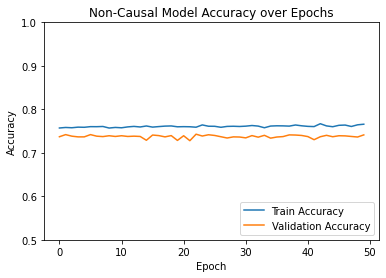

97/97 - 0s - loss: 0.5606 - accuracy: 0.7412 - 88ms/epoch - 904us/step
Non-Causal Model Test Accuracy: 0.7412
Non-Causal Model Test Loss: 0.5606


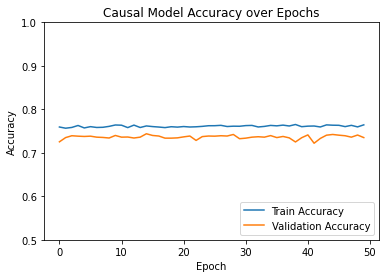

97/97 - 0s - loss: 0.5559 - accuracy: 0.7350 - 84ms/epoch - 870us/step
Causal Model Test Accuracy: 0.7350
Causal Model Test Loss: 0.5559


In [28]:
import matplotlib.pyplot as plt


def plot_accuracy_and_evaluate(
    model: Sequential,
    history: Sequential,
    mfcc_test: dict,
    labels_test: dict,
    model_name: str = "Model",
) -> None:
    """Plottet die Trainings- und Validierungsgenauigkeit.

    :param model: Modell, das evaluiert werden soll
    :param history: Trainingshistorie des Modells
    :param mfcc_test: Testdaten (MFCC)
    :param labels_test: Testlabels
    :param model_name: Name des Modells
    """
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0.5, 1])
    plt.title(f"{model_name} Accuracy over Epochs")
    plt.legend(loc="lower right")
    plt.show()

    test_loss, test_acc = model.evaluate(mfcc_test, labels_test, verbose=2)
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} Test Loss: {test_loss:.4f}")


# Beispielaufruf für das Standardmodell (Mit Zukunftsinformation)
plot_accuracy_and_evaluate(
    non_causal_model, history, mfcc_test, labels_test, model_name="Non-Causal Model"
)

# Beispielaufruf für das Causal Modell (Ohne Zukunftsinformation)
plot_accuracy_and_evaluate(
    causal_model,
    causal_history,
    mfcc_test,
    labels_test,
    model_name="Causal Model",
)
